In [1]:
import numpy as np
import os, cv2, sys
from PIL import Image
from keras_preprocessing.image import array_to_img, img_to_array
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage import transform, data, img_as_float, exposure
from keras.models import *
from keras.optimizers import *

Using TensorFlow backend.
/home/ahmed/anaconda3/envs/deepfake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ahmed/anaconda3/envs/deepfake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ahmed/anaconda3/envs/deepfake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ahmed/anaco

<Figure size 432x288 with 0 Axes>

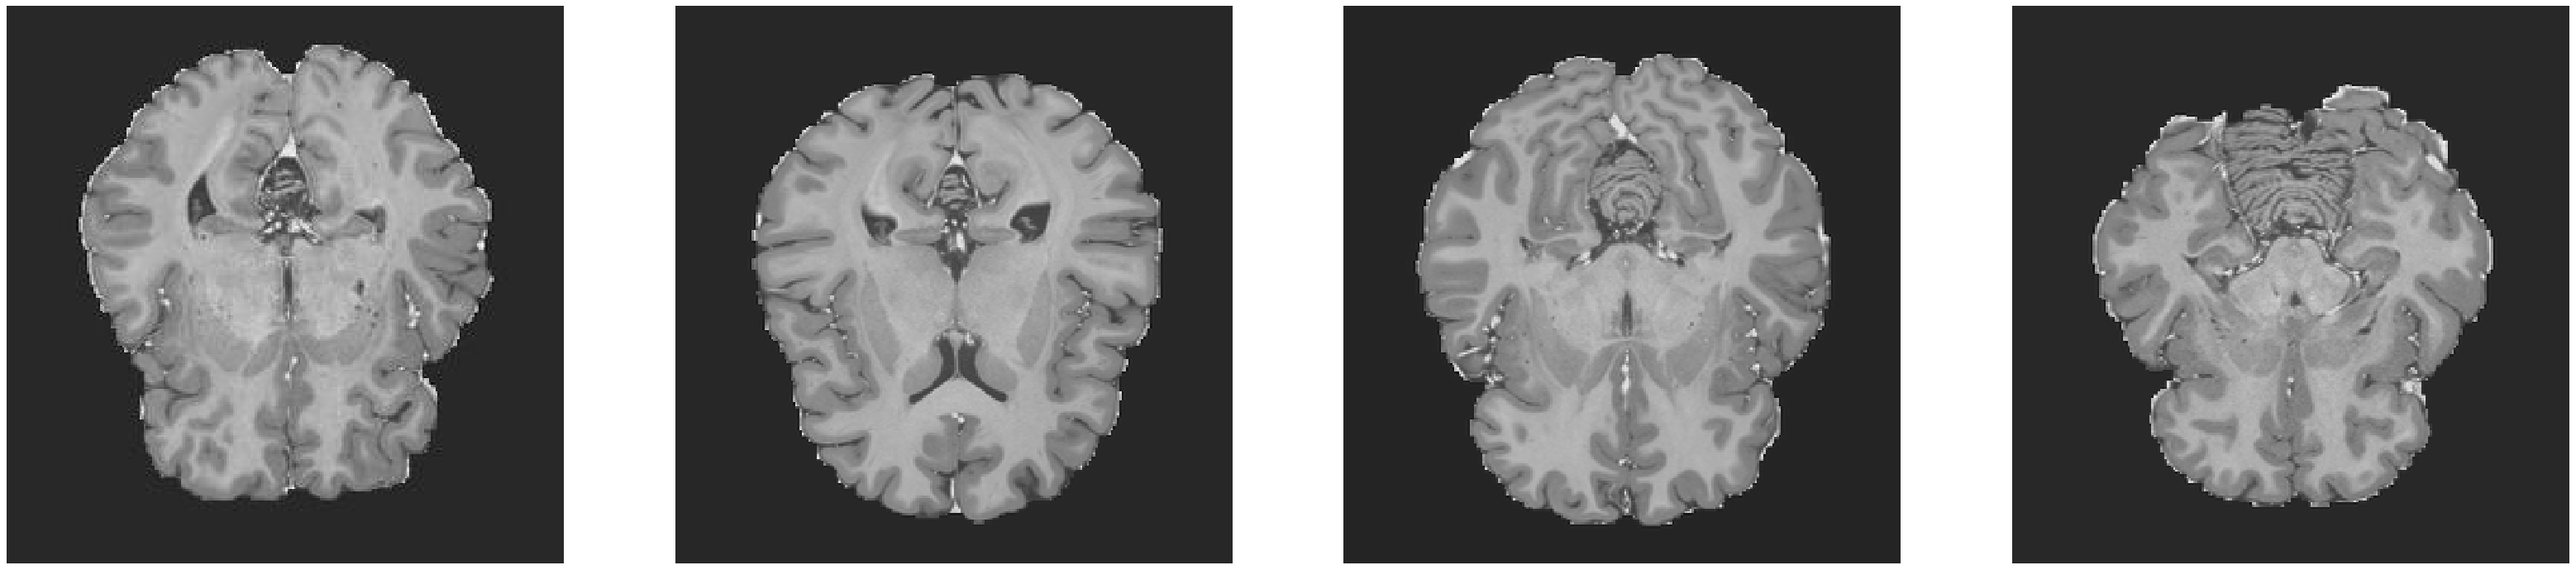

In [2]:
# Sample images:
plt.figure()

# reading images
Image1 = cv2.imread('example_1.jpg')
Image2 = cv2.imread('example_2.png')
Image3 = cv2.imread('example_3.png')
Image4 = cv2.imread('example_4.png')


figure(figsize=(50, 40), dpi=80)

plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(Image1, cmap="gray")
plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(Image2, cmap="gray")
plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(Image3, cmap="gray")
plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(Image4, cmap="gray")
plt.show()

# Define loss and metrics:

In [3]:
def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
           (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
        y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.2), 'float32') * K.cast(K.less(averaged_mask, 0.8), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
           weighted_dice_loss(y_true, y_pred, weight)
    return loss
	
def dice_acc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def jacard_acc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

1/1 [==============================] - 2s 2s/step


<Figure size 432x288 with 0 Axes>

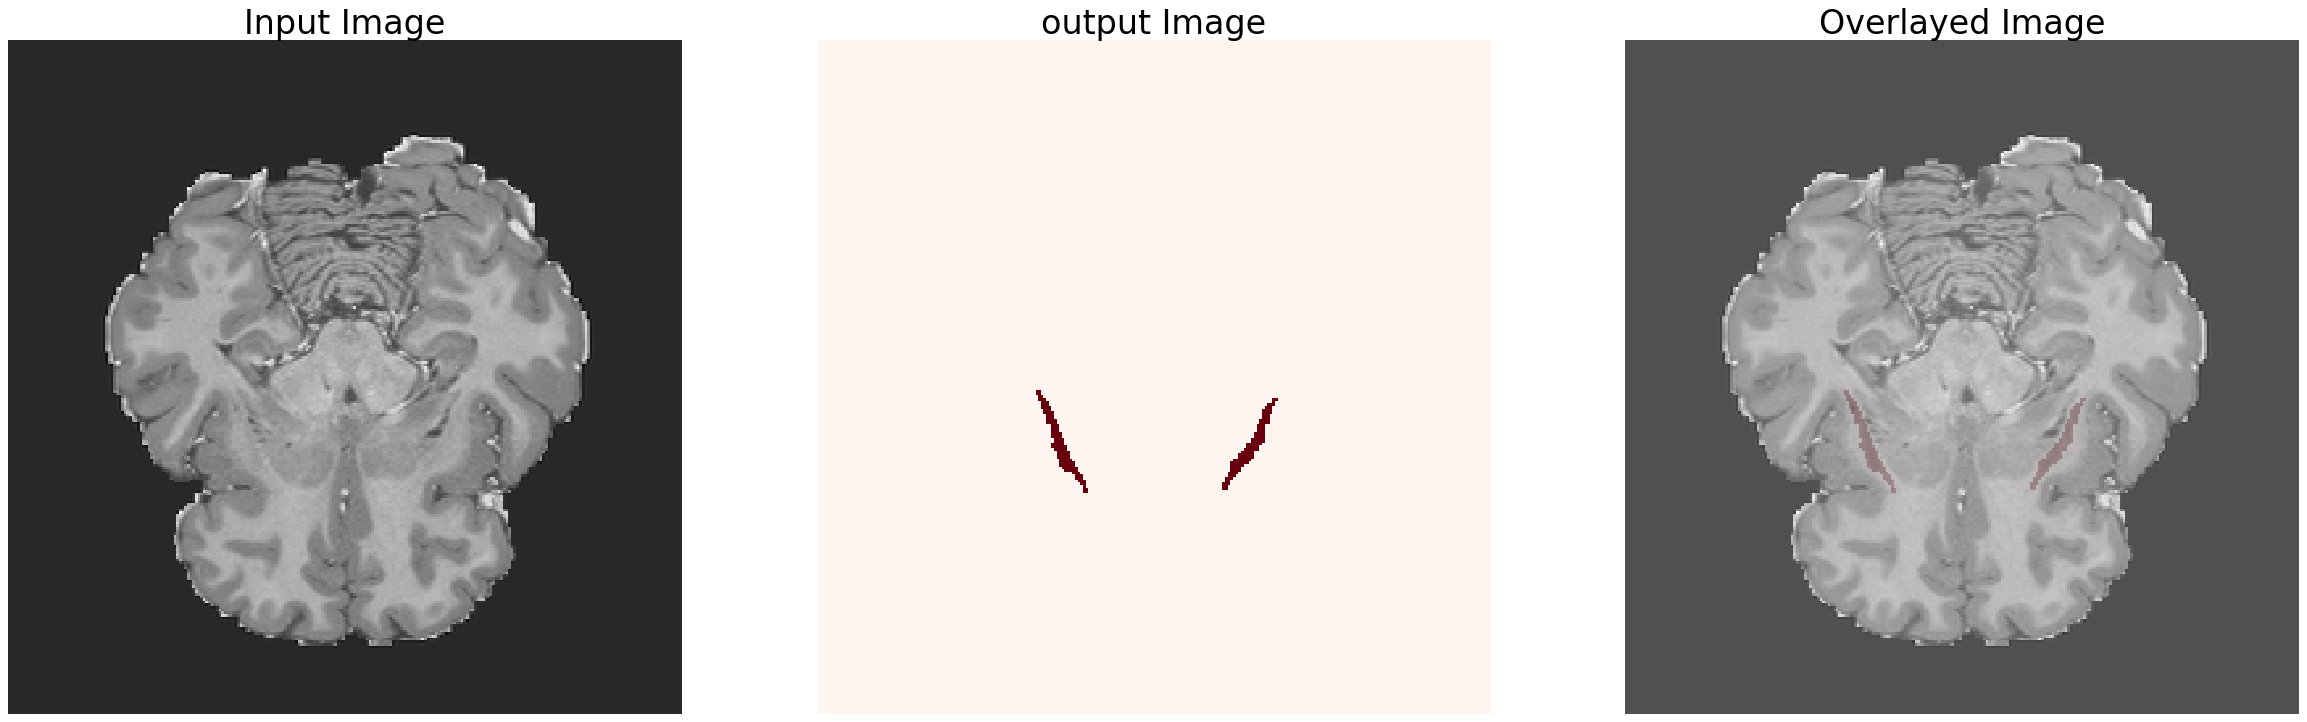

In [11]:
############################
# model path
model_path = "axial_model_82.hdf5"
# image to predict
sample = "example_images/example_4.png" 
# path to save model results
result_path = "results/"
#############################

# load saved model and predict
def predict_CL(scan):

    model = load_model(model_path, custom_objects={'weighted_bce_dice_loss':                   
weighted_bce_dice_loss,'dice_acc':dice_acc,'jacard_acc':jacard_acc})
    predicted_CL = model.predict(scan, verbose=1)

    predicted_CL[predicted_CL >= 0.5] = 1
    predicted_CL[predicted_CL < 0.5] = 0

    return predicted_CL

# Pad predicted image to be (256x256)
def pad_with(c_x):
    n,r = c_x.shape
    c_y = np.zeros((n+160, r+128),dtype=c_x.dtype)
    c_y[100: 196, 62:190] = c_x
    return c_y


# Load image:
img = np.asarray(Image.open(sample))

# Create ndarray with shape (1,96,128):
cropped_test = np.ndarray(shape=(1, 96, 128), dtype=np.float32)

# Select the ROI from input image 
test_asmatrix =  np.asmatrix(img[:,:,0])
lx, ly = test_asmatrix.shape
cropped_test = test_asmatrix[100: 196, 62:190]

# Normalize
norm = (np.amax(cropped_test) - np.amin(cropped_test))
if norm == 0:
    cropped_test = (cropped_test - np.amin(cropped_test))
else:
    cropped_test = (cropped_test - np.amin(cropped_test)) / (np.amax(cropped_test) - np.amin(cropped_test))

# Expand dim
cropped_test = np.expand_dims(cropped_test, axis=0)
cropped_test = np.expand_dims(cropped_test, axis=-1)

# Model predict
pred_CL = predict_CL(cropped_test)


x = 0.5


for y in range(pred_CL.shape[0]):
    pred_CL[y,: , 45:90,0][pred_CL[y,: , 45:90,0] > 0] = 0


# Padding img
new_im = pad_with(pred_CL[0,:,:,0])


# Save model output
#plt.imshow(img, cmap='gray', origin='lower')
#plt.imshow(new_im, cmap='Reds', alpha=0.2)
#plt.axis('off')
#plt.savefig(os.path.join(result_path,'CL Result.jpg'), bbox_inches='tight', pad_inches=0)

# Sample images:
plt.figure()

figure(figsize=(50, 40), dpi=80)

plt.subplot(1, 4, 1)
plt.axis('off')
plt.title('Input Image', fontsize=30)
plt.imshow(img, cmap="gray")
plt.subplot(1, 4, 2)
plt.axis('off')
plt.title('output Image', fontsize=30)
plt.imshow(new_im, cmap="Reds")
plt.subplot(1, 4, 3)
plt.axis('off')
plt.title('Overlayed Image', fontsize=30)
plt.imshow(img, cmap="gray")
plt.imshow(new_im, cmap="Reds", alpha=0.2)
plt.show()

# Result Image from our paper

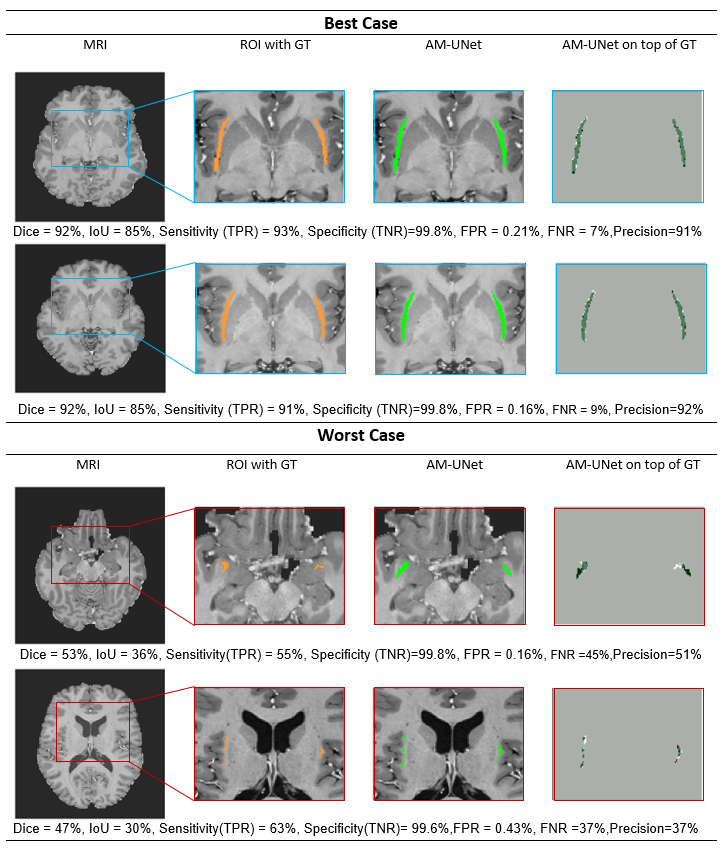